### 0. 导入相关库

In [538]:
import torch
import numpy as np
from d2l import torch as d2l
import math

### 1. 生成人造数据集

$$\mathbf{y}=\mathbf{X}\mathbf{w}+b+\epsilon.$$
生成一个真实参数为$\mathbf{w}=[2,-3.4]^{\top}\mathrm{、}b=4.2$，加入噪声 $\epsilon$服从（0，0.01）的正态分布的人造数据集

In [542]:
true_w=torch.tensor([2.0,-3.4]) #创建一个向量长度为2，对应
true_b=4.2#标量
features=torch.normal(0,1,(1000,len(true_w)))#创建一个服从正态分布(0,1)的输入;形状为(1000,2)
print("features的shape：",features.shape)

features的shape： torch.Size([1000, 2])


In [544]:
#生成未加噪声的y值
y=torch.matmul(features,true_w)+true_b#矩阵运算(1000,2)X(2,1);注意：这里的torch.matmul 会将向量转化成列矩阵参与运算
y_shape=y.shape
print(y_shape)
#加入服从正态分布(0，0.01)的随机噪声
#y+=torch.normal(0,0.01,y_shape)#加入噪声，噪声的长度与y的长度相同
#最后的y则作为labels
labels=y.reshape(-1,1)# 将这个向量reshape成1000x1

torch.Size([1000])


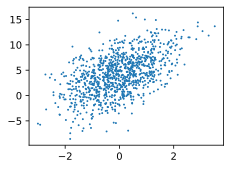

In [546]:
d2l.set_figsize()  
d2l.plt.scatter(features[:, (0)].detach().numpy(), labels.detach().numpy(), 1);

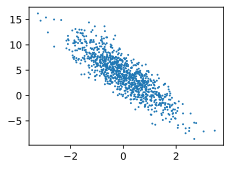

In [547]:
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

说明：在这里w0和w1分别为2，-3.4，根据上面的散点图，可以判断y与x1（x2）之间存在线性关系

### 2.读取数据集

(1）创建一个将数据打乱的函数,这里只是一个演示，实际深度深度学习自带更好的迭代函数

In [553]:
def data_iter(batch_size, features, labels):  
    """
    将一个整个数据集，以batch_size为单元，分成一个个小的组别
    返回一个个小组别中的features和对应的labels
    batch_size:size of BatchSize
    features:X
    labels:Y
    """
    num_examples = len(features)  # 获取特征的样本数量
    indices = list(range(num_examples))  # 创建一个包含所有样本索引的列表
    random.shuffle(indices)  # 随机打乱索引列表，确保数据顺序不固定
    for i in range(0, num_examples, batch_size):  #以batch_size为步长,在(0,num_examples-1)取索引
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])  # 获取batch_size的索引,返回一个长度为batch_size的一维张量
        yield features[batch_indices], labels[batch_indices]  # 返回当前批次的特征和标签，形状分别为(batch_size,num_x))和(batch_size,1)

yield 语句使得这个函数成为一个生成器，每次调用时都会返回一个新的批次数据。调用 data_iter 会返回一个迭代器，每次可以通过 for 循环获取下一个批次。    

### 3.初始化模型参数

In [557]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)  
b = torch.zeros(1, requires_grad=True)

### 4.定义模型

$$\mathbf{y}=\mathbf{X}\mathbf{w}+b$$

In [561]:
def linreg(X, w, b): #@save 
    """
    线性回归模型
    X，w：向量
    b：标量
    """  
    return torch.matmul(X, w) + b

### 5.定义损失函数

$$l^{(i)}(\mathbf{w},b)=\frac{1}{2}\left(\hat{y}^{(i)}-y^{(i)}\right)^2$$

In [565]:
def squared_loss(y_hat, y): #@save  
    """均方损失"""  
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 6.定义一个优化算法

$$(\mathbf{w},b)\leftarrow(\mathbf{w},b)-\frac{\eta}{|B|}\sum_{i\in\mathcal{B}}\partial_{(\mathbf{w},b)}l^{(i)}(\mathbf{w},b).$$
其中${|B|}$是batch_size；${\eta}$是学习率lr；

In [569]:
def sgd(params, lr, batch_size): #@save 
    """小批量随机梯度下降"""  
    with torch.no_grad(): # 在下面的操作中禁用梯度,因为我们只需要更新参数，而不需要反向传播
        for param in params:  
            param -= lr * param.grad / batch_size 
            param.grad.zero_()# 更新完参数后，需要将该参数的梯度清零。因为 PyTorch 默认会累积梯度

### 7.设置超参数以及实例化模型和损失函数

In [572]:
lr = 0.03  
num_epochs = 3  
batch_size = 10
model = linreg  
loss = squared_loss

### 8.训练

In [575]:
for epoch in range(num_epochs):  
    for X, y in data_iter(batch_size, features, labels):  #在一个完整的数据集将其打乱然后分成小的组别进行训练
        l = loss(model(X, w, b), y) # X和y的小批量损失  
        # 因为l形状是(batch_size,1),而不是一个标量。l中的所有元素被加到一起,  
        # 并以此计算关于[w,b]的梯度  
        l.sum().backward()  
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数  
    with torch.no_grad():  
        train_l = loss(model(features, w, b), labels) #将整个训练数据集
        print(f'epoch {epoch + 1}:loss {float(train_l.mean()):f}')

epoch 1:loss 0.040192
epoch 2:loss 0.000100
epoch 3:loss 0.000000


### 9.评估

在本次案例中由于我们知道了真实的参数，可以直接求差值评估

In [579]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')  
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0002, -0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)
